# Train and test new model

Using the saved vector representations as input, i coded a simple MLP to predict the affinity scores. After testing I will apply the same evaluation metrics as for the tankbind model and then compare the 2. Hopefully we where able to improve the error.

In [ ]:
import os
# Set which GPU to use (here, GPU 2) by setting the CUDA_VISIBLE_DEVICES environment variable 
# (important if executed on server, check which GPU is available)
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
gpu_id = device.index
print('Gpu name:', torch.cuda.get_device_name(gpu_id))
print('Memory allocated:', round(torch.cuda.memory_allocated(gpu_id) / (1024 ** 3),2), 'GB')
print('Memory cached:', round(torch.cuda.memory_reserved(gpu_id) / (1024 ** 3),2), 'GB')

Gpu name: Tesla P40
Memory allocated: 0.0 GB
Memory cached: 0.0 GB


In [4]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import torchmetrics
import pandas as pd
from tqdm.notebook import tqdm
import itertools
import matplotlib.pyplot as plt

## Load data (vector representations)

In [5]:
data = torch.load("vector_representations/vector_representations.pt")
labels = torch.load("vector_representations/labels.pt")
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: torch.Size([105634, 128])
Labels shape: torch.Size([105634])


In [6]:
# split into training and test sets
X, X_test, y, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=42) # 0.12 to get around 10_000 samples in validation set

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 74366
Validation set size: 10141
Test set size: 21127


### Normalize the data

Why one might skip normalization here:

- If the vectors are already coming from a pretrained model (self_dockt.pt) where the representation is internally normalized or bounde, further normalization now may not change much.

If time permits try training with and without normalization and see how it affects the perfomance of the model.

**Model performs significantly better with normalized data**

In [ ]:
# fit a scaler to only the training data, then transform the entire dataset with that scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.numpy())

# normalize training set
X_train = torch.tensor(X_train, dtype=torch.float32)

# normalize validation & test set
X_val = torch.tensor(scaler.transform(X_val.numpy()), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test.numpy()), dtype=torch.float32)

### Create dataloaders

In [ ]:
BATCH_SIZE = 64 # set batchsize (depending on GPU memory it can be 64-256 or higher...) 

# Note: for this batchsize the GPU had 24GB RAM and could be set higher for this memory size

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of batches in train loader:      {len(train_loader)},  with n samples: {len(train_loader.dataset)}")
print(f"Number of batches in validation loader: {len(val_loader)},  with n samples: {len(val_loader.dataset)}")
print(f"Number of batches in test loader:       {len(test_loader)},  with n samples: {len(test_loader.dataset)}")

Number of batches in train loader: 1162,  with n samples: 74366
Number of batches in validation loader: 159,  with n samples: 10141
Number of batches in test loader: 331,  with n samples: 21127


# Models

## MLP-Model

In [12]:
class AffinityPredMLP(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, output_dim=1):
        super(AffinityPredMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim) # output_dim is 1 for regression tasks
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize the model and move to the appropriate device
# model = AffinityPredMLP().to(device)
# model = AffinityPredMLP(input_dim=128, hidden_dim=1024, output_dim=1).to(device)

### Functions for training and evaluation

In [ ]:
# Trainin Function (process per epoch)
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).float()  # Ensure y is float for regression

        optimizer.zero_grad()

        preds = model(x)

        loss = criterion(preds.squeeze(), y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(dataloader.dataset)

# evaluation function (for validation and test)
def evaluate(model, dataloader, criterion, type='val'):
    model.eval()
    total_loss = 0.0
    predictions = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device).float()
            preds = model(x)
            loss = criterion(preds.squeeze(), y)
            total_loss += loss.item() * x.size(0)

            if type == 'test': # Uncomment to if you want the predictions and true labels for test set
                predictions.append(preds.detach().cpu().numpy())
                
    if type == 'test':
        return total_loss / len(dataloader.dataset), np.concatenate(predictions)

    return total_loss / len(dataloader.dataset)


### GridSearch for optimal parameter settings

In [ ]:
def grid_search(train_loader, val_loader, param_grid, device):
    best_params = None
    best_score = float('inf')

    keys, vals = zip(*param_grid.items())
    for v in itertools.product(*vals):
        params = dict(zip(keys, v))

        # initialize model with current parameters
        model = AffinityPredMLP(input_dim=128, hidden_dim=params['hidden_dim'], output_dim=1).to(device)

        if params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        elif params['optimizer'] == 'adamw':
            optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        elif params['optimizer'] == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9, weight_decay=params['weight_decay'])

        # train & evaluate
        for epoch in range(1, EPOCHS + 1):
            train_loss = train_epoch(model, train_loader, optimizer, criterion)
            val_loss = evaluate(model, val_loader, criterion)

        print(f"Params: {params}, Val MSE: {val_loss:.4f}")
        if val_loss < best_score:
            best_score = val_loss
            best_params = params
            torch.save(model.state_dict(), "model/best_model_grid_search.pt")

        
    print(f"Best parameters: {best_params}, Best validation MSE: {best_score:.4f}")
    return best_params

In [ ]:
param_grid = {
    'hidden_dim': [256, 512],
    'optimizer': ['adam', 'adamw'],
    'lr': [1e-3, 1e-4, 5e-3, 5e-4],
    'weight_decay': [0.0, 1e-5, 1e-4]
}

best_params = grid_search(train_loader, val_loader, param_grid, device)

## Training loop

**Set hyperparmeters:**

In [ ]:
# hyperparameters
h_dim = 256
model = AffinityPredMLP(input_dim=128, hidden_dim=h_dim, output_dim=1).to(device)

EPOCHS = 500  # 100/200 might be enough, 500 (might) leads to overfitting
LEARNING_RATE = 5e-4

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Adam optimizer with weight decay for regularization
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks

best_val_loss = float('inf') # for best model selection/saving

In [41]:
# training loop
train_losses, val_losses = [], []

for epoch in tqdm(range(1, EPOCHS + 1), desc="Training Progress"):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "model/best_model_500eps_hd1024.pt")
        # print("Best model saved!")

Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/500, Train Loss: 0.6008, Val Loss: 0.6036
Epoch 20/500, Train Loss: 0.5397, Val Loss: 0.5600
Epoch 30/500, Train Loss: 0.5063, Val Loss: 0.5385
Epoch 40/500, Train Loss: 0.4755, Val Loss: 0.6366
Epoch 50/500, Train Loss: 0.4561, Val Loss: 0.5275
Epoch 60/500, Train Loss: 0.4364, Val Loss: 0.5322
Epoch 70/500, Train Loss: 0.4219, Val Loss: 0.5321
Epoch 80/500, Train Loss: 0.4044, Val Loss: 0.5098
Epoch 90/500, Train Loss: 0.3873, Val Loss: 0.5828
Epoch 100/500, Train Loss: 0.3756, Val Loss: 0.4996
Epoch 110/500, Train Loss: 0.3658, Val Loss: 0.5070
Epoch 120/500, Train Loss: 0.3489, Val Loss: 0.4946
Epoch 130/500, Train Loss: 0.3399, Val Loss: 0.4874
Epoch 140/500, Train Loss: 0.3334, Val Loss: 0.5026
Epoch 150/500, Train Loss: 0.3236, Val Loss: 0.4902
Epoch 160/500, Train Loss: 0.3166, Val Loss: 0.4870
Epoch 170/500, Train Loss: 0.3051, Val Loss: 0.4967
Epoch 180/500, Train Loss: 0.3012, Val Loss: 0.5008
Epoch 190/500, Train Loss: 0.2934, Val Loss: 0.4968
Epoch 200/500, Train 

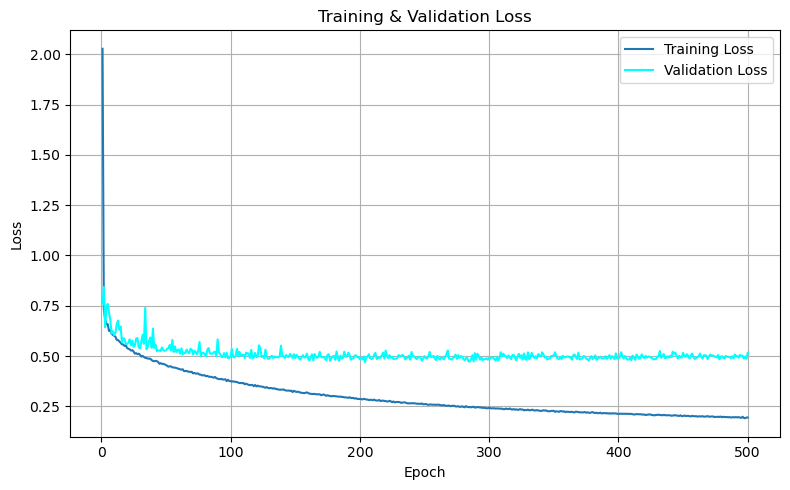

In [ ]:
# plot loss curves
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss', color='cyan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Inference - Get predictions from the MLP model and reshape them 

In [ ]:
model_mlp = AffinityPredMLP(input_dim=128, hidden_dim=h_dim, output_dim=1).to(device)
model_mlp.load_state_dict(torch.load("model/best_model_500eps_hd1024.pt"))

test_loss, preds_mlp = evaluate(model_mlp, test_loader, criterion, 'test')
print(f"Test MSE: {test_loss:.4f}")

In [ ]:
print("Predictions shape:", preds_mlp.shape)
print("First 5 predictions:", preds_mlp[:5])

# change shape of predictions to match true labels
preds_mlp = preds_mlp.squeeze()
print("Final Predictions shape:", preds_mlp.shape)

## LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 74366, number of used features: 128
[LightGBM] [Info] Start training from score 11.717098


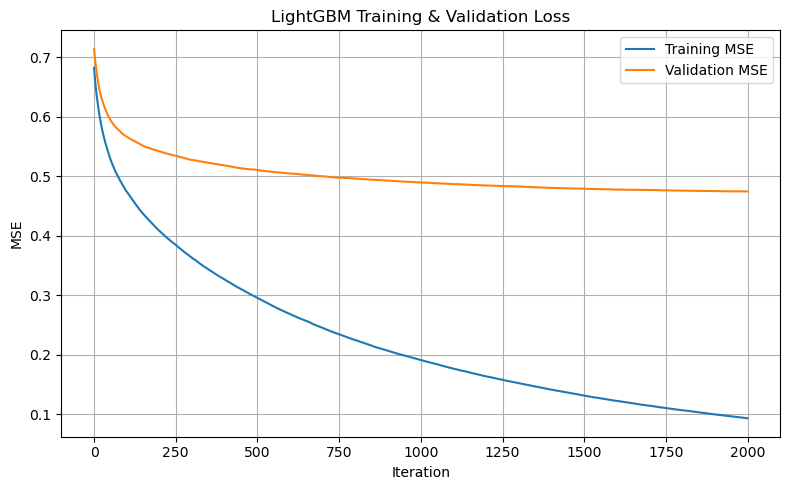

Test MSE for LightGBM: 0.4583


In [ ]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(
    num_leaves=64,  # Number of leaves in one tree
    n_estimators=2000, #1000 # Number of boosting iterations
    learning_rate=0.05,  # Learning rate
    subsample=0.8,  # Fraction of samples to use for each tree
    colsample_bytree=0.8,  # Fraction of features to use for each tree
)

# model_lgb.fit(X_train.numpy(), y_train.numpy(), eval_set=[(X_val.numpy(), y_val.numpy())], eval_metric='mse')
eval_results = {}

model_lgb.fit(
    X_train.numpy(), 
    y_train.numpy(), 
    eval_set=[(X_train.numpy(), y_train.numpy()),(X_val.numpy(), y_val.numpy())], 
    eval_metric='mse', callbacks=[lgb.record_evaluation(eval_results)], 
    )

# plot loss curves
plt.figure(figsize=(8,5))
plt.plot(eval_results['valid_0']['l2'], label='Training MSE') # the training set is the first one in eval_results
plt.plot(eval_results['valid_1']['l2'], label='Validation MSE')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('LightGBM Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# evaluate predictions
preds_lgb = model_lgb.predict(X_test.numpy())
test_loss_lgb = np.mean((preds_lgb - y_test.numpy()) ** 2)
print(f"Test MSE for LightGBM: {test_loss_lgb:.4f}")

# save model
torch.save(model_lgb, "model/lgb_model.pt")

## XGBoost

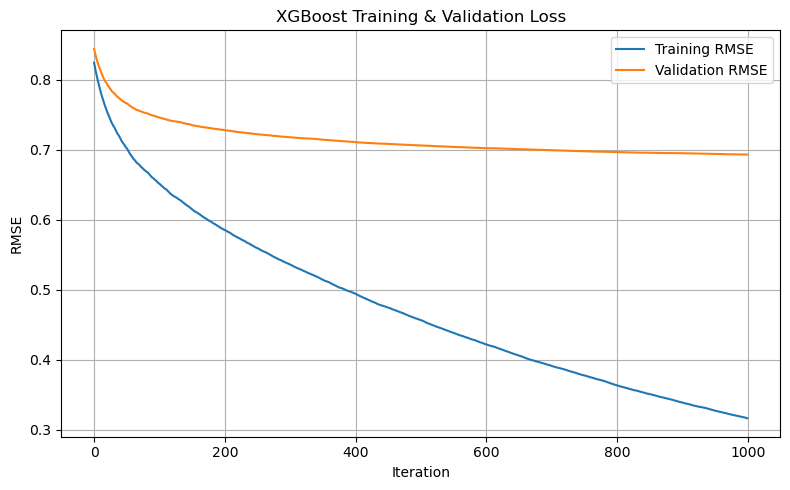

/system/apps/studentenv/hernler/rdkit-env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:27:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Test RMSE for XGBoost: 0.4622


In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(
    n_estimators=1000,  # Number of boosting iterations
    learning_rate=0.05,  # Learning rate
    max_depth=8,  # Maximum depth of the tree
    subsample=0.8,  # Fraction of samples to use for each tree
    colsample_bytree=0.8,  # Fraction of features to use for each tree
    eval_metric='rmse',  # Evaluation metric
    tree_method='hist',  # Use GPU for training
    device=device.type,  # Use the same device as the model
)

# model_xgb.fit(X_train.numpy(), y_train.numpy(), eval_set=[(X_val.numpy(), y_val.numpy())])

model_xgb.fit(
    X_train.numpy(), 
    y_train.numpy(), 
    eval_set=[(X_train.numpy(), y_train.numpy()), (X_val.numpy(), y_val.numpy())], 
    verbose=False
)

results = model_xgb.evals_result()

# plot loss curves
plt.figure(figsize=(8,5))
plt.plot(results['validation_0']['rmse'], label='Training RMSE')
plt.plot(results['validation_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('XGBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# evaluate predictions
preds_xgb = model_xgb.predict(X_test.numpy())
test_loss_xgb = np.mean((preds_xgb - y_test.numpy()) **2)
print(f"Test RMSE for XGBoost: {test_loss_xgb:.4f}")

# save model
torch.save(model_xgb, "model/xgb_model.pt")

# Evaluation

**Mean squared error, mean absolute error & r2-score:**

In [ ]:
def eval_metrics(targets, predictions):
    mse = torchmetrics.functional.mean_squared_error(torch.tensor(predictions), torch.tensor(targets))
    mae = torchmetrics.functional.mean_absolute_error(torch.tensor(predictions), torch.tensor(targets))
    r2 = torchmetrics.functional.r2_score(torch.tensor(predictions), torch.tensor(targets))
    return mse.item(), mae.item(), r2.item()

**Concordance index:**

In [ ]:
def concordance_idx(y_true, y_pred):
    # 1. Convert inputs to NumPy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # 2. Sort by predicted values
    order = np.argsort(y_pred)
    y_true = y_true[order]

    # 3. Find unique labels and group sizes
    unique_labels, inverse = np.unique(y_true, return_inverse=True)
    counts = np.bincount(inverse)  # number of samples per unique label

    print(f"Found {len(unique_labels)} unique labels")

    # 4. Compute cumulative counts
    cum_counts = np.cumsum(counts)  # prefix sum for fast pair counting

    concordant = 0
    total_pairs = 0

    # 5. Iterate over label groups
    for i, count_i in enumerate(tqdm(counts, desc="Processing label groups")):
        # Total pairs with higher labels (since sorted by prediction, no pair expansion)
        higher = cum_counts[-1] - cum_counts[i]
        total_pairs += count_i * higher

        # Since it is sorted by prediction, all these pairs are concordant
        concordant += count_i * higher

    c_index = concordant / total_pairs if total_pairs > 0 else np.nan

    return c_index


In [ ]:
# MLP predictions
mse_mlp, mae_mlp, r2_mlp = eval_metrics(y_test.cpu().numpy(), preds_mlp)
c_idx_mlp = concordance_idx(y_test.cpu().numpy(), preds_mlp)
print(f"MLP -> MSE: {mse_mlp:.4f}, MAE: {mae_mlp:.4f}, R2: {r2_mlp:.4f}, Concordance Index: {c_idx_mlp:.4f}")

# XGBoost predictions
mse_xgb, mae_xgb, r2_xgb = eval_metrics(y_test.cpu().numpy(), preds_xgb)
c_idx_xgb = concordance_idx(y_test.cpu().numpy(), preds_xgb)
print(f"XGBoost -> MSE: {mse_xgb:.4f}, MAE: {mae_xgb:.4f}, R2: {r2_xgb:.4f}, Concordance Index: {c_idx_xgb:.4f}")

# LightGBM predictions
mse_lgb, mae_lgb, r2_lgb = eval_metrics(y_test.cpu().numpy(), preds_lgb)
c_idx_lgb = concordance_idx(y_test.cpu().numpy(), preds_lgb)
print(f"LightGBM -> MSE: {mse_lgb:.4f}, MAE: {mae_lgb:.4f}, R2: {r2_lgb:.4f}, Concordance Index: {c_idx_lgb:.4f}")

### Prediction stacking

In [ ]:
preds_avg = (preds_mlp + preds_lgb + preds_xgb) / 3

mse_avg, mae_avg, r2_avg = eval_metrics(y_test.cpu().numpy(), preds_avg)
c_idx_avg = concordance_idx(y_test.cpu().numpy(), preds_avg)

print(f"Average -> MSE: {mse_avg:.4f}, MAE: {mae_avg:.4f}, R2: {r2_avg:.4f}, Concordance Index: {c_idx_avg:.4f}")

Test MSE: 0.4257, MAE: 0.4343, R2: 0.3999
[Step 1] Converting inputs to NumPy arrays...
[Step 2] Sorting by predicted values...
[Step 3] Finding unique labels and group sizes...
    Found 996 unique labels
[Step 4] Computing cumulative counts...
[Step 5] Iterating over label groups...


Processing label groups:   0%|          | 0/996 [00:00<?, ?it/s]

[Step 6] Finalizing concordance index...
[Done] Concordance Index: 1.0000
Concordance Index (Average): 1.0000
